github link: https://github.com/ral10001/RyanAIML/tree/master/Natural_Language_Processing 
___

# (NLP) Project Description: Twitter US Airline Sentiment

## Data Description:
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

### Dataset:
The project is from a dataset from Kaggle.
Link to the Kaggle project site: https://www.kaggle.com/crowdflower/twitter-airline-sentiment. 
The dataset has to be downloaded from the above Kaggle website.

The dataset has the following columns:
* tweet_id
* airline_sentiment
* airline_sentiment_confidence
* negativereason
* negativereason_confidence
* airline
* airline_sentiment_gold
* name
* negativereason_gold
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location
* user_timezone

## Objective:
To implement the techniques learnt as a part of the course (NLP).

### Import and Load
First we will import the necessary libraries and import our data

In [1]:
import numpy as np                                  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import contractions
import re
import nltk
import unicodedata
from bs4 import BeautifulSoup

from nltk.corpus import stopwords                   
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer               
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('Tweets.csv')
data.shape

(14640, 15)

In [3]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,"14,640.00","14,640.00","10,522.00","14,640.00"
mean,"569,218,351,767,382,528.00",0.90,0.64,0.08
std,"779,111,158,481,836.75",0.16,0.33,0.75
min,"567,588,278,875,213,824.00",0.34,0.00,0.00
25%,"568,559,178,101,439,488.00",0.69,0.36,0.00
50%,"569,477,857,923,110,912.00",1.00,0.67,0.00
75%,"569,890,473,289,000,960.00",1.00,1.00,0.00
max,"570,310,600,460,525,568.00",1.00,1.00,44.00


In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,nan,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,nan,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##### Seeing that we are interested in the text and sentiment within our dataset, I will reduce the columns down to 'text' and 'airline_sentiment'

In [5]:
df = data[['text', 'airline_sentiment']]
df.shape

(14640, 2)

* reduced data from 15 down to 2 columns

In [6]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


##### visualize our target variable distribution

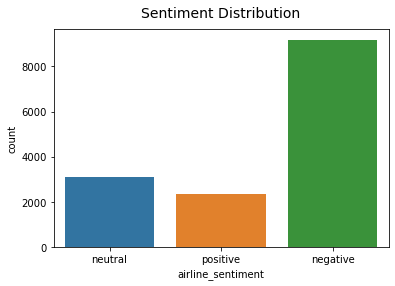

In [7]:
sns.countplot(df.airline_sentiment)
plt.title('Sentiment Distribution', fontdict={'fontsize': 14}, pad=12)
plt.show()

* our target variables are heavily skewed towards the 'negative' label.  This may affect the accuracy of our models. 

### Pre-Process the Data
* Html tag removal.
* Remove contractions
* Remove the numbers.
* Removal of Special Characters and Punctuations.
* Tokenization.
* Conversion to lowercase.
* Remove stopwords
* Lemmatize and/or stemming.

#### Write pre-processing functions
Creating functions to clean up the text, then wrapping all pre-processing functions into the normalize() function.  This wrapper function will be used to pre-process the 'text' column in our dataset.

In [8]:
sw_list = stopwords.words('english')
WNL = WordNetLemmatizer()
#stemmer = LancasterStemmer()

# remove contractions
def rep_cont(words):
    contractions.fix(words)
    return words

#remove html tags
def remove_html(words):
    words = BeautifulSoup(words, 'html.parser').get_text()
    return words

# remove numbers
def remove_nums(words):
    words = re.sub(r'[0-9]', "", words)
    return words

# remove special characters
def remove_sc(words):
    words = re.sub(r'[^\w\s]', " ", words)
    return words

# tokenize strings
def tokenize(words):
    words = word_tokenize(words)
    return words

# remove non_ascii words
def non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    words = new_words
    return words

# make all words lowercase
def lowercasing(words):
    new_words = []
    for word in words:
        # put try block if needed
        new_word = word.lower()
        new_words.append(new_word)
    words = new_words
    return words

# remove stop_words from tokenized words
def stop_words(words, stop_list):
    new_words = [word for word in words if word not in stop_list]
    words = new_words
    return words

# stemming function (for reference)
#def stem(words):
#    stems = []
#    for word in words:
#        stems.append(stemmer.stem(word))
#    return stems

# lemmatizer function
def lemmas(words):
    lemmas = []
    for word in words:
        lemmas.append(WNL.lemmatize(word, pos='v')) # v is for verb, n is for noun
    return lemmas


# run all pre-processing functions on the data and replace each text string with it's respective cleaned, tokenized list
def normalize(col, data, stop_list):
    data2 = data.copy()
    for i, row in data2.iterrows():
        words = data2.at[i, col]
        words = rep_cont(words)
        words = remove_html(words)
        words = remove_nums(words)
        words = remove_sc(words)
        words = tokenize(words)
        words = non_ascii(words)
        words = lowercasing(words)
        words = stop_words(words, stop_list)
        words = lemmas(words)
        
        # set col datapoints at each index/column location
        data2.at[i, col] = words
        
    detokenize = lambda x: ' '.join(x)
    data2[col] = data2[col].apply(detokenize)   
    return data2


#### Pre-process the 'text' column
Printing out a sample of cleaned data after cleaning the text.  Note the magic method _%%time_ being used.  This is showing how long it takes to run the normalize() function

__What is occuring here?__
* replacing contractions
* removing html tags, numbers, and special characters
* tokenizing the words
* removing non-ascii characters
* lowercasing all words
* removing stop words
* lemmatizing words

In [9]:
%%time

df_clean = normalize(col='text', data=df, stop_list=sw_list)
df_clean.head()

CPU times: user 6.81 s, sys: 243 ms, total: 7.06 s
Wall time: 7.07 s


,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience ...,positive
2,virginamerica today must mean need take anothe...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


### Vectorization
Now that we have pre-processed our text, we can 'vectorize' our text.  Essentially, we will convert our text into numbers so we can run it through a classification model (ie random forest)

#### Bag of Words
vectorize our text data using the CountVectorizer() method

In [10]:
# instantiate the vectorizer module of choice
vectorizer = CountVectorizer(max_features=1000)

# fit and transform the vectorized data into a matrix
vector_fit = vectorizer.fit_transform(df_clean.text)

# make the matrix into an array and view the results
vector = vector_fit.toarray()
vector.shape

(14640, 1000)

##### Next we can look at our vocabulary. There should be 1000 words based on the max_features parameter being set to 1000.  We will print the top 5 out of 1000 from our vocab dictionary.

In [11]:
vocab_bow = vectorizer.vocabulary_
print('vocab_bow type: ', type(vocab_bow))
print('number of words: ', len(vocab_bow))
print('Top 5 items: ', list(vocab_bow.items())[:5], '\n')

vocab_bow type:  <class 'dict'>
number of words:  1000
Top 5 items:  [('virginamerica', 942), ('say', 767), ('plus', 670), ('add', 12), ('experience', 314)] 



##### Also, I am printing the vector below just to see a sample of the vectorized text data

In [12]:
vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### Next, we can set our X and y variables based on the bag of words vector we just created

In [13]:
X_bow = vector
y_bow = df_clean['airline_sentiment']

#### TF*IDF
vectorize our text data using the CountVectorizer() method

In [14]:
# instantiate the tf-idf vectorizer method
tf_vectorizer = TfidfVectorizer(max_features=1000)

# fit and transform the text
tf_fit = tf_vectorizer.fit_transform(df_clean.text)

# turn the tf-idf matrix into an array and print the shape
tf_vector = tf_fit.toarray()
tf_vector.shape

(14640, 1000)

In [15]:
vocab_tfi = tf_vectorizer.vocabulary_
print(f'vocab_tfi type: {type(vocab_tfi)}')
print(f'number of words: {len(vocab_tfi)}')
print(f'Top 5 items: {list(vocab_tfi.items())[:5]} \n')

vocab_tfi type: <class 'dict'>
number of words: 1000
Top 5 items: [('virginamerica', 942), ('say', 767), ('plus', 670), ('add', 12), ('experience', 314)] 



##### Let's do the same for the idf values of our vectorized data

In [16]:
idf_vals = tf_vectorizer.idf_
print(f'number of idf values: {len(idf_vals)}')
print(f'first 10 idf vals: \n {idf_vals[:10]} \n')

number of idf values: 1000
first 10 idf vals: 
 [4.98946227 5.79579055 7.45608688 7.15759389 7.09507353 7.41352726
 6.90270164 7.29574423 6.23487226 7.64714211] 



##### Again, I am printing the vector below just to see a sample of the vectorized text data

In [17]:
tf_vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Finally, we can set our X and y variables based on the TF*IDF vector we just created

In [18]:
X_tfi = tf_vector
y_tfi = df_clean['airline_sentiment']

### Modeling
**Steps include:**
* splitting the data
* fitting the model (random forest) to the training set
* printing the accuracy score
* predicting the results
* printing a confusion matrix

#### Splitting the data
we will do this for both sets of vectorized data (Bag of Words and TF*IDF)

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score

In [20]:
# bag of words data
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size = .25, random_state=14)

# TFIDF data
X_train_tfi, X_test_tfi, y_train_tfi, y_test_tfi = train_test_split(X_tfi, y_tfi, test_size = .25, random_state=14)

#### Random Forest with Bag of Words 
Applying a Random Forest model on our bag of words vectorized data

In [21]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the RandomForestClassifier() method
rfc_bow = RandomForestClassifier(random_state=14, n_jobs=3)

# fit the algorithm to our training data
rfc_bow.fit(X_train_bow, y_train_bow)

# store the predictions in the pred_bow variable
pred_bow = rfc_bow.predict(X_test_bow)

# print out the accuracy score
acc_bow = rfc_bow.score(X_test_bow, y_test_bow)
print(f'Accuracy Score: {round(acc_bow, 3)}')

Accuracy Score: 0.748


##### Confusion Matrix (BoW)
Visualizing the classification results for the Bag of Words data via a confusion matrix

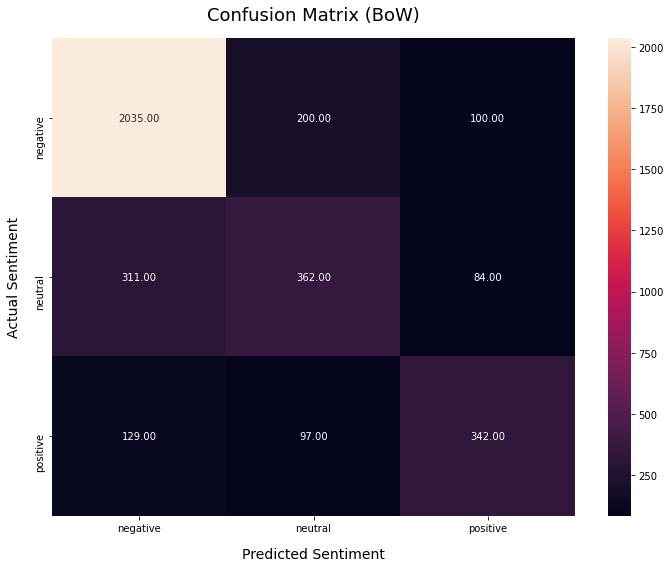

,Accuracy Score
0,0.75


In [22]:
from sklearn.metrics import confusion_matrix

# creating the confusion matrix
labels = list(y_test_bow.unique())
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
cm_bow = confusion_matrix(y_test_bow, pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='.2f', yticklabels=labels, xticklabels=labels)
ax.set_ylabel('Actual Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_xlabel('Predicted Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_title('Confusion Matrix (BoW)', fontdict={'fontsize': 18}, pad=18)
plt.show()

# Printing accuracy again but as a dataframe
pd.DataFrame({'Accuracy Score': [round(acc_bow, 3)]})


##### Observations:
* The accuracy score looks alright at 0.75.  I will look further into metrics in a bit.
* The confusion matrix shows me that the model is best at predicting negative sentiment. From a total of 2,335 instances of negative sentiments, the model accurately predicted 2,035 of these tweets.  Recall is about 87% (2035/2335).
* The model struggles a bit with neutral comments. Only 362 of 757 were accurately predicted, giving us a recall of only about 48% (362/757).  311 of the 757 neutral tweets were predicted as having a negative sentiment.
* Positive sentiment predictions fair a bit better than neutral predictions with 342 of 568 accurate predictions with a recall of 60% (342/568). It is a bit concerning that 129 of these positive tweets were classified as negative (22% of actual positives).  This may tell us that the vocabulary from our vectorized data could be tweaked a bit.  Perhaps we can review the stop words that were removed, or look into n-grams.

#### Random Forest with TF*IDF

In [23]:
# instantiate the RandomForestClassifier() method
rfc_tfi = RandomForestClassifier(random_state=14, n_jobs=3)

# fit the algorithm to our training data
rfc_tfi.fit(X_train_tfi, y_train_tfi)

# store the predictions in the pred_tfi variable
pred_tfi = rfc_tfi.predict(X_test_tfi)

# print out the accuracy score
acc_tfi = rfc_tfi.score(X_test_tfi, y_test_tfi)
print(f'Accuracy Score: {round(acc_bow, 3)}')

Accuracy Score: 0.748


##### Confusion Matrix (TF*IDF)
Visualizing the classification results for the TF*IDF data via a confusion matrix

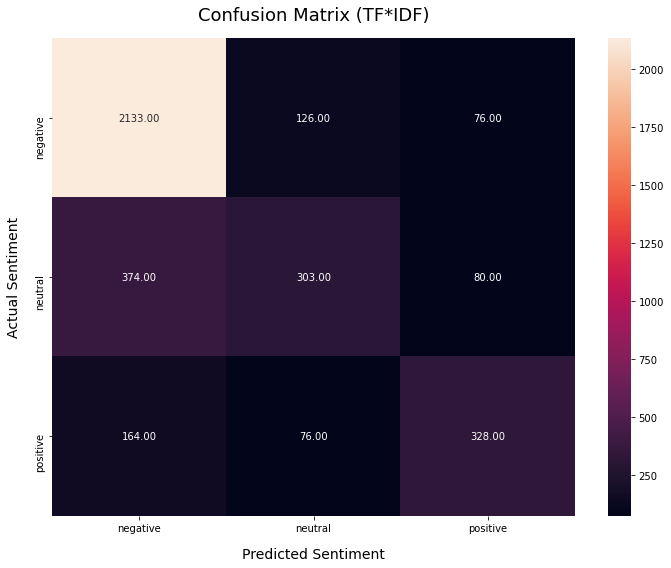

,Accuracy Score (TF*IDF)
0,0.75


In [24]:
labels = list(y_test_tfi.unique())
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
cm_tfi = confusion_matrix(y_test_tfi, pred_tfi)
sns.heatmap(cm_tfi, annot=True, fmt='.2f', yticklabels=labels, xticklabels=labels)
ax.set_ylabel('Actual Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_xlabel('Predicted Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_title('Confusion Matrix (TF*IDF)', fontdict={'fontsize': 18}, pad=18)
plt.show()
pd.DataFrame({'Accuracy Score (TF*IDF)': [round(acc_bow, 3)]})

##### Observations:
* The accuracy score looks alright once again at 0.75.
* Similar to the bag of words data, the confusion matrix for our TF*IDF vectorized data shows me that the model is best at predicting negative sentiment. From a total of 2,335 instances of negative sentiments, the model accurately predicted 2,133 of these tweets. This is slightly better than our BoW model.  Recall for the TF*IDF data is about 91% (2133/2335).
* Similar to our BoW model, we are again struggling a bit with neutral comments. Only 303 of 757 were accurately predicted (slightly less than our BoW model), giving us a recall of only about 40% (303/757).  374 of the 757 neutral tweets were predicted as having a negative sentiment (more than the 311 incorrect negative sentiments we saw in the BoW vectorized data).
* Positive sentiment predictions fair a bit better than neutral predictions with 328 of 568 accurate predictions with a recall of 58% (328/568).  This is the BoW model was comparable at 60% recall for positive sentiments. Again, it is a bit concerning that 164 of these positive tweets were classified as negative (29% of actual positives).  This may further prove to us that the vocabulary from our vectorized data could be adjusted.  Perhaps we can review the stop words that were removed, or look into utilizing n-grams.
* I would also like to note that there are a fair bit more negative sentiments.  **This may be the main cause for the skewed performance of our models across different sentiments.**

#### Classification Reports

##### Bag of Words Random Forest Report

In [25]:
from sklearn.metrics import classification_report

cr_bow = pd.DataFrame(classification_report(y_test_bow, pred_bow, output_dict=True))
cr_bow

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.82,0.55,0.65,0.75,0.67,0.74
recall,0.87,0.48,0.60,0.75,0.65,0.75
f1-score,0.85,0.51,0.63,0.75,0.66,0.74
support,"2,335.00",757.00,568.00,0.75,"3,660.00","3,660.00"


##### TF*IDF Random Forest Report

In [26]:
cr_tfi = pd.DataFrame(classification_report(y_test_tfi, pred_tfi, output_dict=True))
cr_tfi

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.80,0.60,0.68,0.76,0.69,0.74
recall,0.91,0.40,0.58,0.76,0.63,0.76
f1-score,0.85,0.48,0.62,0.76,0.65,0.74
support,"2,335.00",757.00,568.00,0.76,"3,660.00","3,660.00"


#### Further Observations
The above classification reports further prove our initial observations from the confusion matrix and accuracy scores for our models

    1. Support cases are heavily skewed toward negative sentiments making up about 64% of our test datapoints.
    2. The Precision, Recall, and f1-score metrics highlight the skewed predictive nature of our models. We see very solid metrics for negative sentiments, fairly average predicitve capacity for positive sentiments, and poor metrics for neutral tweets.

### Summary
* The initial text was a bit messy.  It had special characters, capitals, numbers, etc. within various tweets.  Cleaning this text up narrowed our scope of words our model would need to process.  For example, the words 'Flight', 'flight', and 'flights' would all be considered as indivual words.  By pre-processing the text, I was able to categorize all of these words into the single 'flight' word through lowercasing and lemmatization.
* The various pre-processing steps used to accomplish cleaning like the example above included: 
    * replacing contractions
    * removing html tags, numbers, and special characters
    * tokenizing the words
    * removing non-ascii characters
    * lowercasing all words
    * removing stop words
    * lemmatizing words
* All of this pre-processing greatly reduces dimensionality, further improving a potential models efficiency
* I further reduced dimensionality by setting the max features of each vectorizer (CountVectorizer aka bag of words, and TfidfVectorizer) to 1000 words.  This made it so the data included only the top 1000 words, helping to generalize a model that would be fed this data.
* Overall, the models performed fairly well with both of them achieving an accuracy score of 0.75.  Both models performed better on tweets with negative sentiments.  This could mainly be due to the data skewness.  Negative sentiments accounted for around 64% of our data.
* One way to potentially improve this model is to adjust the words included.  We could do this by removing some key words for our stopwords list, allowing them to be utilized in the model.
* Another option would be to utilize n-grams instead of single words.

___

## Further Refinement

#### Stop words and N-gram tuning

Let's serach for a common word that may occur in tweets and is also in our current stopword list.  I am going to go with 'not'

In [27]:
# searching for not in the text column from the initial dataframe

word = 'not'

i_list = []
t_list = []
for i, t in enumerate(df.text):
    if word in t:
        i_list.append(i)
        t_list.append(t)

print(len(t_list))

1856


In [28]:
import random

# choosing a random index number from our datapoints with the word 'not'
i = random.choice(i_list)
i

13920

In [29]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

# comparing the original text value with the cleaned text
print(df.iloc[i])
print(df_clean.iloc[i])

text                 @AmericanAir Thanks - I note some, but not all, flights are Cancelled Flightled - are only some aircraft/runways working out of DFW today/tomorrow?
airline_sentiment                                                                                                                                               negative
Name: 13920, dtype: object
text                 americanair thank note flight cancel flightled aircraft runways work dfw today tomorrow
airline_sentiment                                                                                   negative
Name: 13920, dtype: object


* after running through the above steps several times, I have identified a list of several words to look for in the stop words list that may be worth removing

In [30]:
words = ['not', 'no', 'nothing', 'was']

for word in words: 
    print(word in sw_list)

True
True
False
True


Removing some stop words below in the try block

In [31]:
sw_new = sw_list

for word in words:
    try:
        sw_new.remove(word)
    except ValueError:
        pass

# test to prove that 'not' was removed
'not' in sw_new

False

In [32]:
%%time

df_new = normalize(col='text', data=df, stop_list=sw_new)
df_new.head()

CPU times: user 6.47 s, sys: 97.3 ms, total: 6.57 s
Wall time: 6.58 s


,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience tacky,positive
2,virginamerica today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,negative
4,virginamerica really big bad thing,negative


### Vectorization take 2

#### Bag of Words
vectorize our text data using the CountVectorizer() method

In [33]:
# instantiate the vectorizer module of choice
vectorizer = CountVectorizer(max_features=1000)

# fit and transform the vectorized data into a matrix
vector_fit = vectorizer.fit_transform(df_new.text)

# make the matrix into an array and view the results
vector = vector_fit.toarray()
vector.shape

(14640, 1000)

In [34]:
X_bow = vector
y_bow = df_new['airline_sentiment']

#### TF*IDF
vectorize our text data using the CountVectorizer() method

In [35]:
# instantiate the tf-idf vectorizer method
tf_vectorizer = TfidfVectorizer(max_features=1000)

# fit and transform the text
tf_fit = tf_vectorizer.fit_transform(df_new.text)

# turn the tf-idf matrix into an array and print the shape
tf_vector = tf_fit.toarray()
tf_vector.shape

(14640, 1000)

In [36]:
X_tfi = tf_vector
y_tfi = df_new['airline_sentiment']

### Modeling

In [37]:
# bag of words data
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size = .25, random_state=14)

# TFIDF data
X_train_tfi, X_test_tfi, y_train_tfi, y_test_tfi = train_test_split(X_tfi, y_tfi, test_size = .25, random_state=14)

#### Random Forest with Bag of Words 
Applying a Random Forest model on our bag of words vectorized data

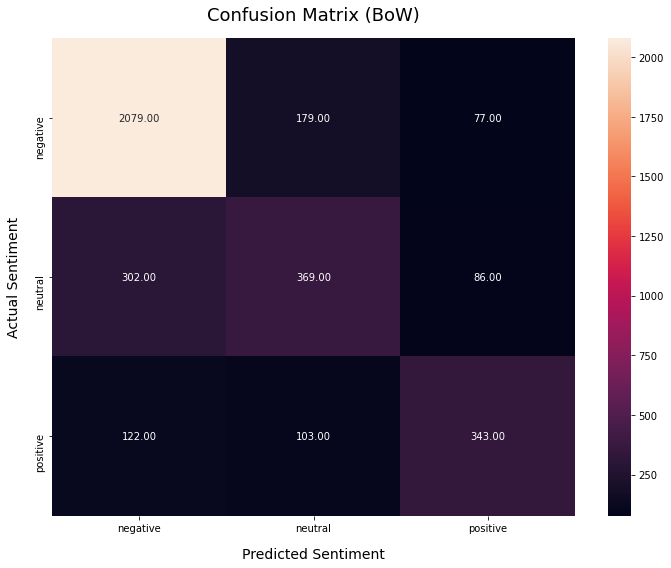

,Accuracy Score
0,0.76


In [38]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the RandomForestClassifier() method
rfc_bow = RandomForestClassifier(random_state=14, n_jobs=3)

# fit the algorithm to our training data
rfc_bow.fit(X_train_bow, y_train_bow)

# store the predictions in the pred_bow variable
pred_bow = rfc_bow.predict(X_test_bow)

# accuracy score
acc_bow = rfc_bow.score(X_test_bow, y_test_bow)

# creating the confusion matrix
labels = list(y_test_bow.unique())
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
cm_bow = confusion_matrix(y_test_bow, pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='.2f', yticklabels=labels, xticklabels=labels)
ax.set_ylabel('Actual Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_xlabel('Predicted Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_title('Confusion Matrix (BoW)', fontdict={'fontsize': 18}, pad=18)
plt.show()

# Printing accuracy again but as a dataframe
pd.DataFrame({'Accuracy Score': [round(acc_bow, 3)]})


#### Random Forest with TF*IDF

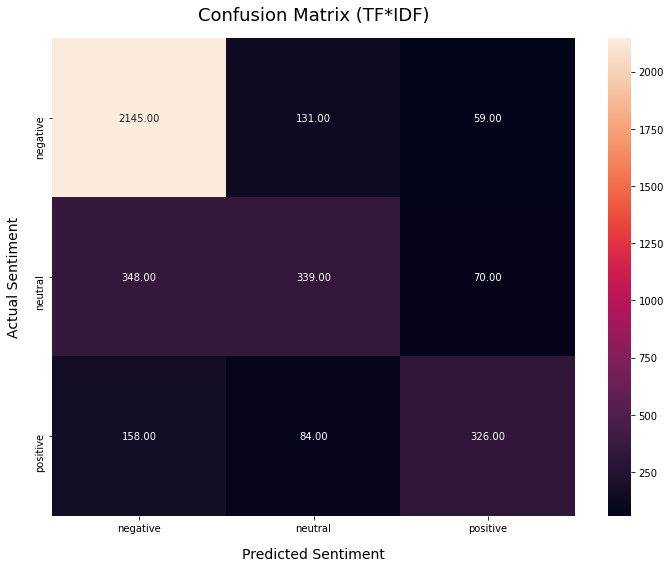

,Accuracy Score (TF*IDF)
0,0.76


In [39]:
# instantiate the RandomForestClassifier() method
rfc_tfi = RandomForestClassifier(random_state=14, n_jobs=3)

# fit the algorithm to our training data
rfc_tfi.fit(X_train_tfi, y_train_tfi)

# store the predictions in the pred_tfi variable
pred_tfi = rfc_tfi.predict(X_test_tfi)

# accuracy score
acc_tfi = rfc_tfi.score(X_test_tfi, y_test_tfi)

# confusion matrix
labels = list(y_test_tfi.unique())
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
cm_tfi = confusion_matrix(y_test_tfi, pred_tfi)
sns.heatmap(cm_tfi, annot=True, fmt='.2f', yticklabels=labels, xticklabels=labels)
ax.set_ylabel('Actual Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_xlabel('Predicted Sentiment', fontdict={'fontsize': 14}, labelpad=14)
ax.set_title('Confusion Matrix (TF*IDF)', fontdict={'fontsize': 18}, pad=18)
plt.show()
pd.DataFrame({'Accuracy Score (TF*IDF)': [round(acc_bow, 3)]})

#### Compare Classification Reports

##### Bag of Words (CountVectorizer)

New metrics

In [40]:
new_cr_bow = pd.DataFrame(classification_report(y_test_bow, pred_bow, output_dict=True))
new_cr_bow

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.83,0.57,0.68,0.76,0.69,0.75
recall,0.89,0.49,0.60,0.76,0.66,0.76
f1-score,0.86,0.52,0.64,0.76,0.67,0.76
support,"2,335.00",757.00,568.00,0.76,"3,660.00","3,660.00"


Former metrics

In [41]:
cr_bow

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.82,0.55,0.65,0.75,0.67,0.74
recall,0.87,0.48,0.60,0.75,0.65,0.75
f1-score,0.85,0.51,0.63,0.75,0.66,0.74
support,"2,335.00",757.00,568.00,0.75,"3,660.00","3,660.00"


* Overall, the bag of words model performed similarly the second time around with a slight increase in all metrics

#### TF*IDF

New metrics

In [42]:
new_cr_tfi = pd.DataFrame(classification_report(y_test_tfi, pred_tfi, output_dict=True))
new_cr_tfi

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.81,0.61,0.72,0.77,0.71,0.75
recall,0.92,0.45,0.57,0.77,0.65,0.77
f1-score,0.86,0.52,0.64,0.77,0.67,0.75
support,"2,335.00",757.00,568.00,0.77,"3,660.00","3,660.00"


Former metrics

In [43]:
cr_tfi

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.80,0.60,0.68,0.76,0.69,0.74
recall,0.91,0.40,0.58,0.76,0.63,0.76
f1-score,0.85,0.48,0.62,0.76,0.65,0.74
support,"2,335.00",757.00,568.00,0.76,"3,660.00","3,660.00"


* The tfidf model performed a bit better the second time around.  Most notably, the f1-score for the neutral labels improved by 0.04. 

Lastly, let's see how the tfidf model will perform when vectorizing the data with n-grams

#### N-grams
Using the ngram_range parameter in the TF*IDF vectorizer

In [44]:
tfv = TfidfVectorizer(max_features=1000, ngram_range = (2,2)) # setting ngram_range to use bi-grams
tfv_fit = tfv.fit_transform(df_new.text)

# turn the tf-idf matrix into an array and print the shape
tfv_vector = tfv_fit.toarray()
tfv_vector.shape

(14640, 1000)

In [45]:
X_tfv = tfv_vector
y_tfv = df_new['airline_sentiment']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_tfv, y_tfv, test_size = .25, random_state=14)

In [47]:
rf = RandomForestClassifier(random_state=14, n_jobs=3)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc_ngram = rf.score(X_test, y_test)

pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.74,0.44,0.64,0.69,0.61,0.66
recall,0.88,0.28,0.45,0.69,0.54,0.69
f1-score,0.80,0.34,0.53,0.69,0.56,0.67
support,"2,335.00",757.00,568.00,0.69,"3,660.00","3,660.00"


* A quick look at the metrics and we can see that the model performs worse when using bi-grams, without adjusting any other hyperparameters